# Exploration of ParticleNet-style Architecture for Top Tagging Jet Dataset

In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
import numpy as np
import sys
import os
import h5py
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader

sys.path.append("/global/homes/d/danieltm/ExaTrkX/Tracking-ML-Exa.TrkX/Pipelines/TrackML_Example/LightningModules")
from Embedding.utils import build_edges
from pytorch3d import ops

device = "cuda" if torch.cuda.is_available() else "cpu"

# Roadmap

Start by building outside of Lightning modules
1. Load data
2. Write model architecture
3. Write training function
4. Write training loop
5. Define validation metrics

Now, convert to Lightning module for portability

## Load Data

In [3]:
input_dir = "/global/cscratch1/sd/danieltm/ExaTrkX/top_tagging/raw_input"
train_file = "train.h5"
val_file = "val.h5"
test_file = "test.h5"

In [4]:
with pd.HDFStore(os.path.join(input_dir, train_file), mode='r') as store:
    train_df = store['table']
with pd.HDFStore(os.path.join(input_dir, val_file), mode='r') as store:
    val_df = store['table']
with pd.HDFStore(os.path.join(input_dir, test_file), mode='r') as store:
    test_df = store['table']

### Construct Graph

1. Include phi, eta features in vectors
2. Run KNN edge builder phi-eta space

In [5]:
def calc_eta_phi(x, y, z):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(r, z)
    eta = -1. * np.log(np.tan(theta / 2.))
    phi = np.arctan2(y, x)
    
    return eta, phi

In [6]:
def get_eta_phi_values(jet_tuple):
    
    energies = np.array([getattr(jet_tuple, f'E_{i}') for i in range(200)])
    x_values = np.array([getattr(jet_tuple, f'PX_{i}') for i in range(200)])
    y_values = np.array([getattr(jet_tuple, f'PY_{i}') for i in range(200)])
    z_values = np.array([getattr(jet_tuple, f'PZ_{i}') for i in range(200)])

    existing_jet_mask = energies > 0
    energies, x_values, y_values, z_values = energies[existing_jet_mask], x_values[existing_jet_mask], y_values[existing_jet_mask], z_values[existing_jet_mask]

    eta_values, phi_values = calc_eta_phi(x_values, y_values, z_values)
    
    X = torch.from_numpy(np.stack([x_values, y_values, z_values, eta_values, phi_values])).T
    energies = torch.from_numpy(energies)
    
    return X, energies

In [7]:
def build_dataset(dataframe, num_jets = None):
    
    all_X, all_energies, all_y = [], [], []
    if num_jets is not None:
        subsample = dataframe.sample(n = num_jets)
    else:
        subsample = dataframe

    for jet in subsample.itertuples():

        X, energies = get_eta_phi_values(jet)
        y = torch.tensor(jet.is_signal_new)

        all_X.append(X)
        all_energies.append(energies)
        all_y.append(y)
        
    return all_X, all_energies, all_y

In [8]:
class JetDataset(Dataset):
    
    def __init__(self, X, E, y):
        super(JetDataset).__init__()
        
        self.X = X
        self.E = E
        self.y = y
        
    def __len__(self):
        
        return len(self.X)
    
    def __getitem__(self, idx):
        
        this_X = self.X[idx].float()
        this_E = self.E[idx].float()
        this_y = self.y[idx].long()
        
        sample = {"X": this_X, "E": this_E, "y": this_y}
        
        return sample

In [9]:
%%time
all_X, all_energies, all_y = build_dataset(train_df, 1000)
train_dataset = JetDataset(all_X, all_energies, all_y)
train_loader = DataLoader(train_dataset)

CPU times: user 2.41 s, sys: 10.7 s, total: 13.1 s
Wall time: 2min 12s


In [10]:
%%time
all_X, all_energies, all_y = build_dataset(val_df, 100)
val_dataset = JetDataset(all_X, all_energies, all_y)
val_loader = DataLoader(val_dataset)

CPU times: user 471 ms, sys: 2.52 s, total: 2.99 s
Wall time: 26.7 s


### Visualize Graph

In [187]:
edges = build_edges(jetdataset[0]["X"][:, -2:], 1, 10)

CPU times: user 2.03 ms, sys: 133 µs, total: 2.16 ms
Wall time: 1.64 ms


CPU times: user 1.96 s, sys: 57.8 ms, total: 2.02 s
Wall time: 2.08 s


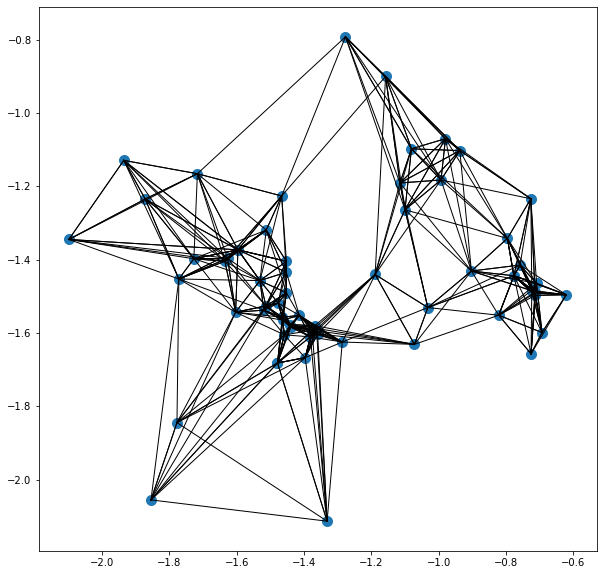

In [186]:
%%time
plt.figure(figsize=(10,10))
for edge in edges.T:
    plt.plot(jetdataset[0]["X"][edge, -2], jetdataset[0]["X"][edge, -1], c="k", linewidth=1)
plt.scatter(jetdataset[0]["X"][:, -2], jetdataset[0]["X"][:, -1], s=100)

# ProtoParticleNet

## Model Architecture

We begin by emulating the ParticleNet architecture, with a simplification: The graph is only constructed **once**

In [11]:
import torch
import torch.nn as nn
from torch_scatter import scatter_mean

In [12]:
def make_mlp(
    input_size,
    sizes,
    hidden_activation="ReLU",
    output_activation="ReLU",
    layer_norm=False,
    batch_norm=False
):
    """Construct an MLP with specified fully-connected layers."""
    hidden_activation = getattr(nn, hidden_activation)
    if output_activation is not None:
        output_activation = getattr(nn, output_activation)
    layers = []
    n_layers = len(sizes)
    sizes = [input_size] + sizes
    # Hidden layers
    for i in range(n_layers - 1):
        layers.append(nn.Linear(sizes[i], sizes[i + 1]))
        if layer_norm:
            layers.append(nn.LayerNorm(sizes[i + 1]))
        if batch_norm:
            layers.append(nn.BatchNorm1d(sizes[i + 1]))
        layers.append(hidden_activation())
    # Final layer
    layers.append(nn.Linear(sizes[-2], sizes[-1]))
    if output_activation is not None:
        if layer_norm:
            layers.append(nn.LayerNorm(sizes[-1]))
        if batch_norm:
            layers.append(nn.BatchNorm1d(sizes[-1]))
        layers.append(output_activation())
    return nn.Sequential(*layers)

In [26]:
class EdgeConv(nn.Module):
    """
    A module which computes weights for edges of the graph.
    For each edge, it selects the associated nodes' features
    and applies some fully-connected network layers with a final
    sigmoid activation.
    """

    def __init__(
        self,
        input_dim,
        hidden_dim,
        nb_layers,
        hidden_activation="ReLU",
        batch_norm=True,
    ):
        super(EdgeConv, self).__init__()
        self.network = make_mlp(
            input_dim * 2,
            [hidden_dim] * nb_layers,
            hidden_activation=hidden_activation,
            output_activation="ReLU",
            batch_norm=batch_norm,
        )

    def forward(self, x, edge_index):
        # Select the features of the associated nodes
        start, end = edge_index
        
        messages = scatter_mean(x[start] - x[end], end, dim=0, dim_size=x.shape[0])
        node_inputs = torch.cat([x, messages], dim=1)
        
        return self.network(node_inputs).squeeze()

class ProtoParticleNet(nn.Module):
    """
    A simplified version of the ParticleNet architecture
    """

    def __init__(self, input_dim, hidden_dim, nb_layers, r_max, k_max,
                 n_graph_iters=3, batch_norm=True):
        super(ProtoParticleNet, self).__init__()
        self.n_graph_iters = n_graph_iters

        # The node encoder transforms input node features to the hidden space
        self.node_encoder = make_mlp(input_dim, [hidden_dim]*nb_layers)

        # The edge network computes new edge features from connected nodes
        self.edge_conv = EdgeConv(hidden_dim, hidden_dim, nb_layers, batch_norm=batch_norm)

        # The edge classifier computes final edge scores
        self.graph_classifier = make_mlp(hidden_dim,
                                        [hidden_dim, 2],
                                        output_activation=None)
        
        # Graph building options
        self.r_max, self.k_max = r_max, k_max

        
    def forward(self, X, E):

        # 1. Build graph
        edges = build_edges(X.squeeze(), self.r_max, self.k_max)
        
        # 2. Encode features
        input_features = torch.cat([X, E.unsqueeze(-1)], dim=-1)
        convoluted_nodes = self.node_encoder(input_features).squeeze()
        
        # 3. Run edge conv x 3
        
        for i in range(self.n_graph_iters):
            skip_connection = convoluted_nodes
            convoluted_nodes = self.edge_conv(convoluted_nodes, edges)
            convoluted_nodes += skip_connection
        
        # 4. Apply global average
        global_average = convoluted_nodes.mean(dim=0)
        
        # 5. Apply FC classifier
        classified_output = self.graph_classifier(global_average)
        
        return classified_output
        

## Training Function

Model configuration:

In [27]:
model_config = {"input_dim": 6, 
          "hidden_dim": 128,
          "nb_layers" : 3,
          "r_max" : 1.,
          "k_max" : 16}

In [28]:
model = ProtoParticleNet(**model_config).to(device)

## Training Loop

Training configuration

In [29]:
train_config = {"n_epochs": 200,
               "lr": 1e-3,
               "factor": 0.3,
               "patience": 50}

In [30]:
optimizer = torch.optim.AdamW(model.parameters(), lr=train_config["lr"])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=train_config["factor"], 
                                                       step_size=train_config["patience"])
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
for epoch in range(train_config["n_epochs"]):
    
    print(f"Epoch: {epoch}")
    
    total_loss = 0
    val_loss = 0
    tp = 0
    
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()

        X, E, y = batch["X"].to(device), batch["E"].to(device), batch["y"].to(device)
        output = model(X, E)

        loss = loss_fn(output.unsqueeze(0), y)
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    scheduler.step()
    print(f"Train Loss: {total_loss}")
    
    for i, batch in enumerate(val_loader):
        
        X, E, y = batch["X"].to(device), batch["E"].to(device), batch["y"].to(device)
        output = model(X, E)
        prediction = output.argmax()
        
        loss = loss_fn(output.unsqueeze(0), y)
        val_loss += loss.item()
        
        tp += (prediction == y).item()
        
    print(f"Val Loss: {val_loss}, Accuracy: {tp/len(val_loader)}")

Epoch: 0
Train Loss: 687.300833525951
Val Loss: 68.61713641403435, Accuracy: 0.64
Epoch: 1
Train Loss: 648.7094740076027
Val Loss: 71.88909577135564, Accuracy: 0.65
Epoch: 2
Train Loss: 631.0955679010937
Val Loss: 68.67422950737819, Accuracy: 0.63
Epoch: 3
Train Loss: 621.2394065909903
Val Loss: 67.54910129342898, Accuracy: 0.65
Epoch: 4
Train Loss: 609.882877474538
Val Loss: 67.13531241043893, Accuracy: 0.66
Epoch: 5
Train Loss: 601.9968929046445
Val Loss: 69.36835995259935, Accuracy: 0.68
Epoch: 6
Train Loss: 600.4301778323168
Val Loss: 67.0773132427363, Accuracy: 0.67
Epoch: 7
Train Loss: 592.229954160458
Val Loss: 68.91191992976195, Accuracy: 0.68
Epoch: 8
Train Loss: 589.6027009425316
Val Loss: 69.98724257522412, Accuracy: 0.68
Epoch: 9
Train Loss: 587.9134166017568
Val Loss: 69.00673248112429, Accuracy: 0.69
Epoch: 10
Train Loss: 582.5354992570335
Val Loss: 64.48188517707257, Accuracy: 0.68
Epoch: 11
Train Loss: 583.9435723617064
Val Loss: 61.57802071033001, Accuracy: 0.71
Epoch:

In [25]:
sum([batch["y"] for batch in train_dataset])

tensor(504)